In [2]:
import json
import sys
import pandas as pd
import numpy as np

# TODO: Check whether spacy is allowed
import spacy

In [3]:
def convert_label(label):
    if label == "rumour":
        return 1
    elif label == "non-rumour":
        return 0
    else:
        raise Exception("label classes must be 'rumour' or 'non-rumour'")

In [4]:
def convert_prediction(pred):
    if pred == 1:
        return "rumour"
    elif pred == 0:
        return "non-rumour"
    else:
        raise Exception("prediction classes must be '0' or '1'")

In [5]:
def load_data(data_file, label_file):
    
    if label_file != None:
        y_true = json.load(open(label_file))
    
    with open(data_file, 'r') as data_train:
        raw_list = list(data_train)

    data_list = []


    for event in raw_list:
        event_chain = json.loads(event)

        tweet = {}

        tweet['id'] = event_chain[0]['id']
        tweet['text'] = event_chain[0]['text']
        
        # append text from follow-up tweets in tweet chain
        for i in range(1, len(event_chain)):
            tweet['text'] += event_chain[i]['text']
        
        if label_file != None:
            tweet['label'] = convert_label(y_true[str(tweet['id'])])
        data_list.append(tweet)

    df = pd.DataFrame(data_list)

    return df


    

In [6]:
train_df = load_data(data_file = '../data/train.data.jsonl', label_file = '../data/train.label.json')
dev_df = load_data(data_file = '../data/dev.data.jsonl', label_file = '../data/dev.label.json')


In [7]:
test_df = load_data(data_file = '../data/test.data.jsonl', label_file = None)

In [8]:
combined_df = train_df.append(dev_df, ignore_index = True)

In [9]:
combined_df

,id,text,label
0,552800070199148544,How to respond to the murderous attack on Char...,0
1,544388259359387648,"You can't condemn an entire race, nation or re...",0
2,552805970536333314,Attempts to extend blame for this to all Musli...,0
3,525071376084791297,"Rest in Peace, Cpl. Nathan Cirillo. Killed tod...",1
4,498355319979143168,People DEBATING whether #MikeBrown shoplifted ...,0
...,...,...,...
5216,525025279803424768,The soldier shot dead in Wednesday's Ottawa at...,1
5217,552784600502915072,Charlie Hebdo became well known for publishing...,0
5218,499696525808001024,We got through. That's a sniper on top of a ta...,0
5219,580320612155060224,Last position of Germanwings flight #4U9525 at...,1


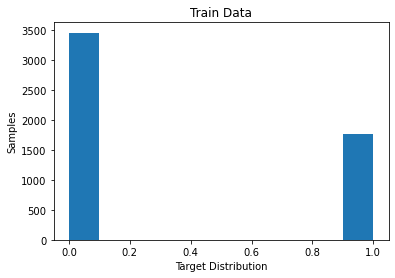

In [10]:
import matplotlib.pyplot as plt
plt.title('Train Data')
plt.xlabel('Target Distribution')
plt.ylabel('Samples')
plt.hist(combined_df.label)
plt.show()

## Preprocessing

1--> Removing Contraction (Decontraction)

2--> Dealing with HashTags

3--> Removing URLs and Email

4--> Removing Stopwords and Lemmatization

In [11]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
import spacy
import re
nlp = spacy.load("en_core_web_sm")

def preprocessing(text):
    text = text.replace('#','')
    text = decontracted(text)
    text = re.sub('\S*@\S*\s?','',text)
    text = re.sub('http[s]?:(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)

    token=[]
    result=''
    text = re.sub('[^A-z]', ' ',text.lower())

    text = nlp(text)
    for t in text:
        if not t.is_stop and len(t)>2:  
            token.append(t.lemma_)
    result = ' '.join([i for i in token])

    return result.strip()

In [14]:
combined_df.text = combined_df.text.apply(lambda x : preprocessing(x))
test_df.text = test_df.text.apply(lambda x : preprocessing(x))

## Loading BertTokenizer

Load tokenizer based on wordpiece approach

In [15]:
# TODO: Check whether transformerss is allowed
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [16]:
import numpy as np
import tensorflow as tf 

## BERT encoding

Data is encoded according to BERT requirement.There is a very helpful function called encode_plus provided in the Tokenizer class. It can seamlessly perform the following operations:

Tokenize the text
Add special tokens - [CLS] and [SEP]

Add special tokens - [CLS] and [SEP]

create token IDs

Pad the sentences to a common length

Create attention masks for the above PAD tokens

In [17]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []


    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,

        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Input are 2 Numpy array. Let me briefly go over them:

1) input_ids : list of token ids to be fed to a model

2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

Note : Token Ids are not necessary as it is used Two Sentence Problem (To differentiate two sentence)

In [18]:
combined_input_ids,combined_attention_masks = bert_encode(combined_df,60)
test_input_ids,test_attention_masks = bert_encode(test_df,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
len(combined_input_ids)

5221

## Creating Custom Model

Base TFBert Model with Dense layer and sigmoid activation as head.

In [25]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=1, average='macro')])
    return model

## TFBertModel

The bare Bert Model transformer outputing raw hidden-states without any specific head on top. https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel

In [26]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Implementing custom model

In [27]:
model = create_model(bert_model)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 335141888   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           32800       tf_bert_model_1[0][1] 

## Training

Fit for **4 epochs**:

In [28]:
history = model.fit([combined_input_ids,combined_attention_masks],combined_df.label,validation_split=0.2, epochs=2,batch_size=10)

Epoch 1/2
418/418 [==============================] - 409s 978ms/step - loss: 0.5179 - accuracy: 0.7368 - precision: 0.6453 - recall: 0.5091 - f1_score: 0.5091 - val_loss: 0.3763 - val_accuracy: 0.8335 - val_precision: 0.7322 - val_recall: 0.7791 - val_f1_score: 0.4953
Epoch 2/2
418/418 [==============================] - 404s 965ms/step - loss: 0.3555 - accuracy: 0.8487 - precision: 0.7804 - recall: 0.7749 - f1_score: 0.5091 - val_loss: 0.3619 - val_accuracy: 0.8545 - val_precision: 0.8117 - val_recall: 0.7267 - val_f1_score: 0.4953


In [37]:
history_new = model.fit([combined_input_ids,combined_attention_masks],combined_df.label,validation_split=0.2, epochs=5,batch_size=10)

Epoch 1/5
418/418 [==============================] - 404s 966ms/step - loss: 0.1188 - accuracy: 0.9576 - precision: 0.9298 - recall: 0.9474 - f1_score: 0.5091 - val_loss: 0.4757 - val_accuracy: 0.8450 - val_precision: 0.7809 - val_recall: 0.7355 - val_f1_score: 0.4953
Epoch 2/5
418/418 [==============================] - 402s 963ms/step - loss: 0.0737 - accuracy: 0.9775 - precision: 0.9644 - recall: 0.9698 - f1_score: 0.5091 - val_loss: 0.5230 - val_accuracy: 0.8536 - val_precision: 0.8687 - val_recall: 0.6541 - val_f1_score: 0.4953
Epoch 3/5
418/418 [==============================] - 404s 966ms/step - loss: 0.0580 - accuracy: 0.9828 - precision: 0.9741 - recall: 0.9755 - f1_score: 0.5091 - val_loss: 0.5431 - val_accuracy: 0.8555 - val_precision: 0.8164 - val_recall: 0.7238 - val_f1_score: 0.4953
Epoch 4/5
418/418 [==============================] - 403s 965ms/step - loss: 0.0500 - accuracy: 0.9859 - precision: 0.9790 - recall: 0.9797 - f1_score: 0.5091 - val_loss: 0.6080 - val_accuracy:

In [40]:
acc = history_new.history['accuracy']
val_acc = history_new.history['val_accuracy']
loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

In [41]:
history_new.history

{'loss': [0.11881187558174133,
  0.07371192425489426,
  0.05802756920456886,
  0.050043489784002304,
  0.04772499203681946],
 'accuracy': [0.9576149582862854,
  0.9774904251098633,
  0.982758641242981,
  0.9858716726303101,
  0.9849137663841248],
 'precision': [0.9298003911972046,
  0.9644351601600647,
  0.9740896224975586,
  0.978976845741272,
  0.9755756855010986],
 'recall': [0.9474053382873535,
  0.969845712184906,
  0.9754558205604553,
  0.9796633720397949,
  0.9803646802902222],
 'f1_score': [0.5091038942337036,
  0.5091038942337036,
  0.5091038942337036,
  0.5091038942337036,
  0.5091038942337036],
 'val_loss': [0.4757072925567627,
  0.5230112671852112,
  0.5431427359580994,
  0.6080405116081238,
  0.5403830409049988],
 'val_accuracy': [0.8449760675430298,
  0.8535885214805603,
  0.8555023670196533,
  0.8468899726867676,
  0.8593301177024841],
 'val_precision': [0.7808641791343689,
  0.8687258958816528,
  0.8163934350013733,
  0.7893081903457642,
  0.7957957983016968],
 'val_rec

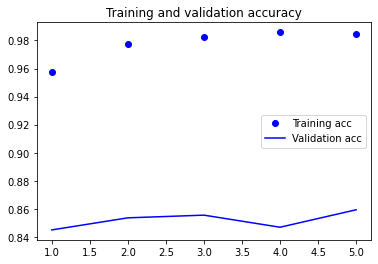

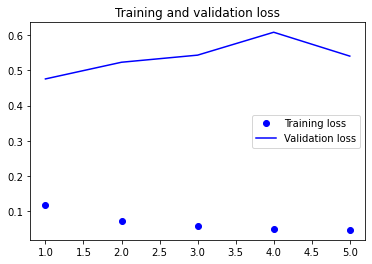

In [42]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Testing

In [43]:
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)

In [44]:
predicted_labels = [convert_prediction(pred) for pred in result]

In [45]:
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})

In [46]:
output

,id,target
0,544382249178001408,rumour
1,525027317551079424,rumour
2,544273220128739329,rumour
3,499571799764770816,non-rumour
4,552844104418091008,non-rumour
...,...,...
576,553581227165642752,non-rumour
577,552816302780579840,non-rumour
578,580350000074457088,rumour
579,498584409055174656,non-rumour


In [47]:
submission = pd.Series(output.target.values,index=output.id).to_dict()

In [48]:
with open('test-output.json', 'w') as f:
    json.dump(submission, f)